In [20]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
#gpu_fraction = 0.1
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [5]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [6]:
y_val = np.load('/srv/hd5/data/vprov/y_val.np.npy')
data_lpmt = np.load('/srv/hd5/data/vprov/lpmt_proj.np.npy')

In [7]:
data_lpmt = data_lpmt.reshape((*data_lpmt.shape, 1))

In [8]:
import keras
import keras.layers as L
from keras.models import Sequential

Using TensorFlow backend.


In [9]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9237755561500029369, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9885951591
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 16516151868125577097
 physical_device_desc: "device: 0, name: Tesla K40m, pci bus id: 0000:83:00.0, compute capability: 3.5"]

In [17]:
model = Sequential()
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=512, kernel_size=(3,3),activation='relu'))
model.add(L.Flatten())
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(3))

In [18]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
model.build(input_shape=(None, 151,151,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 149, 149, 128)     1280      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 256)       590080    
__________

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.3, random_state=45)

In [26]:
X_train.shape, y_train.shape

((7000, 151, 151, 1), (7000, 3))

In [28]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('log.csv', append=True, separator=';')

In [ ]:
out = model.fit(X_train, y_train, batch_size=32, 
                epochs=180, 
                callbacks=[csv_logger], 
                validation_data=(X_test, y_test))

Train on 7000 samples, validate on 3000 samples
Epoch 1/180
7000/7000 [==============================] - 48s 7ms/step - loss: 12030773.3749 - val_loss: 3274920.3473
Epoch 2/180
3072/7000 [============>.................] - ETA: 20s - loss: 2478234.2708

In [32]:
import pandas as pd

In [34]:
cs = pd.read_csv('log.csv', sep=';')

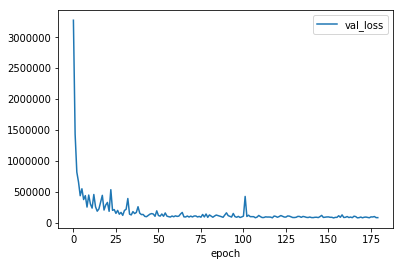

In [40]:
cs.plot(x='epoch',y='val_loss')

In [41]:
model.save_weights('10.02.2019long.h5')

In [42]:
with open("model10.02long.json", "w") as json_file:
    json_file.write(model.to_json())

In [43]:
from sklearn.metrics.pairwise import paired_euclidean_distances

In [44]:
# in mm
test_results = paired_euclidean_distances(model.predict(X_test), y_test)

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

(0, 1000)

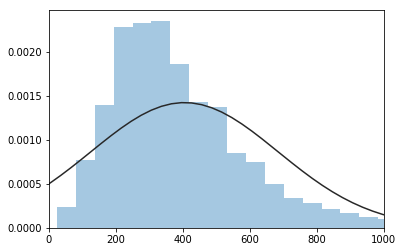

In [48]:
sns.distplot(test_results, kde=False, fit=stats.norm, bins=100)
plt.xlim(0,1000)

In [49]:
test_results.mean()/10

40.478805095559686

In [53]:
results = model.predict(X_test)

In [54]:
xs = results[:,0] - y_test[:,0]

(-1000, 1000)

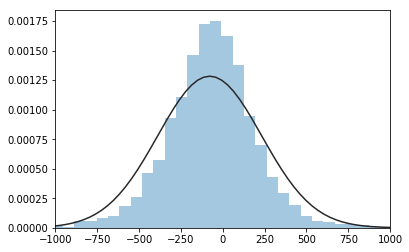

In [57]:
sns.distplot(xs, kde=False, fit=stats.norm, bins=100)
plt.xlim(-1000,1000)

In [59]:
abs(xs).mean()/10

21.422522304369796

In [ ]:
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
# 
## evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)